# <font color='gren'> Exercício 5


In [508]:
import numpy as np
import matplotlib.pylab as plt
import scipy
from scipy.sparse import linalg
from scipy.sparse import csc_matrix
import time


## 1 - Funções auxiliares com modificações para o círculo central


* Pré-setagem

In [509]:
N=41
rtol=1e-5

* Função para plotar os curvas de nível constante de temperatura

In [510]:
# Função para plotar os curvas de nível constante de temperatura
def PlotaTemperature(n,m,T):
    x = np.arange(0, n, 1)
    y = np.arange(0, m, 1)
    X,Y=np.meshgrid(x,y)
    Z = np.copy(T)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_aspect('equal')
    ax.set(xlabel='x', ylabel='y', title='Contours of temperature')
    im = ax.contourf(X, Y, Z.T, 20, cmap='jet')
    im2 = ax.contour(X, Y, Z.T, 20, linewidths=0.25, colors='k')
    fig.colorbar(im, ax=ax)
    plt.show()

* Função que adiciona temperatura a um círculo central a placa com um dado raio (que vai de 0.0 a 1.0 da largura da placa) -> sendo necessário in

In [511]:
# Função para converter indice (i,j) a indice global Ic
def ij2n (i, j, N):
    return (i + j*N)

def simgeral_temp_circ(N,Atilde,A,b,TC,R): #Para os métodos iterativos gerais com preservação de simetria
    if(0<=R and R<=1):
        for i in range(0,N):
            for j in range(0,N):
                if( ( i-(N-1)/2 )**2  +  ( j-(N-1)/2 )**2 < (R*(N-1))**2 ): #Faz a verificação se está dentro
                    Ic=ij2n(i,j,N)
                    for k in range(0,N**2):
                        b[k]=b[k]-A[k][Ic]
                    b[Ic]=TC
                    Atilde[Ic][:]=0
                    Atilde[:][Ic]=0
                    Atilde[Ic][Ic]=1
       
        
                    
            

* Métodos de montagem explícita da matriz A

In [512]:

# Função para montar a matriz do sistema
def MatAssembly(N,R):
    nunk = N**2
    A = np.zeros(shape=(nunk,nunk))
    for i in range(1,N-1):
        for j in range(1,N-1):
            if( ( i-(N-1)/2 )**2  +  ( j-(N-1)/2 )**2 >= (R*(N-1))**2):
                Ic = ij2n(i,   j,   N)
                Ie = ij2n(i+1, j,   N)
                Iw = ij2n(i-1, j,   N)
                In = ij2n(i,   j+1, N)
                Is = ij2n(i,   j-1, N)
                k=np.array([Ic,Ie,Iw,In,Is])
                A[Ic,k] =[4.0, -1.0, -1.0, -1.0, -1.0]
    return A

* Condições de borda mantendo a simetria

*Observação: para cada Ic[r] o elemento aij correspondete a uma terperatura de borda na matriz b passará 
para o outro lado subtraindo aij x Tj*

In [513]:
# Função para modificar a matriz e incorporar as condições de borda
def BuildSystemSim(N, TL, TR, TB, TT, TC, R):
    nunk = N**2
    A = MatAssembly(N,R)
    Atilde = A.copy()
    b = np.zeros(shape=(nunk))
    k = np.array(range(0,N))
    Iden = np.identity(nunk)

    simgeral_temp_circ(N,Atilde,A,b,TC,R)

    Ic = ij2n(0,k,N) # Tleft
    for r in k:
        b[:] = b[:] - A[:,Ic[r]]*TL 
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TL
    Atilde[:,Ic] = Iden[:,Ic]

    Ic = ij2n(N-1,k,N) # Tright
    for r in k:
        b[:] = b[:] - A[:,Ic[r]]*TR
    #somente os termos b[Ic[k]] com k variando de 0 a N-1, correspondentes a uma borda,
    #tem a temperatura dessa respectiva borda
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TR
    Atilde[:,Ic] = Iden[:,Ic]
    
    Ic = ij2n(k,0,N) # Tbottom
    for r in k:
        b[:] = b[:] - A[:,Ic[r]]*TB 
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TB
    Atilde[:,Ic] = Iden[:,Ic]

    Ic = ij2n(k,N-1,N) # Ttop
    for r in k:
        b[:] = b[:] - A[:,Ic[r]]*TT
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TT
    Atilde[:,Ic] = Iden[:,Ic]
    
    return Atilde, b

# 2 - Resolvendo com métodos iterativos avançados

In [514]:

class gmres_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
    def __call__(self, rk=None):
        self.niter += 1
        if self._disp:
            print('iter %3i\trk = %s' % (self.niter, str(rk)))
            
import inspect
class cg_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
    def __call__(self, rk=None):
        self.niter += 1
        frame = inspect.currentframe().f_back
        if self._disp:
            print('iter %3i\trk = %f' % (self.niter, frame.f_locals['resid']))


### Plots das curvas de temperatura

* Método direto

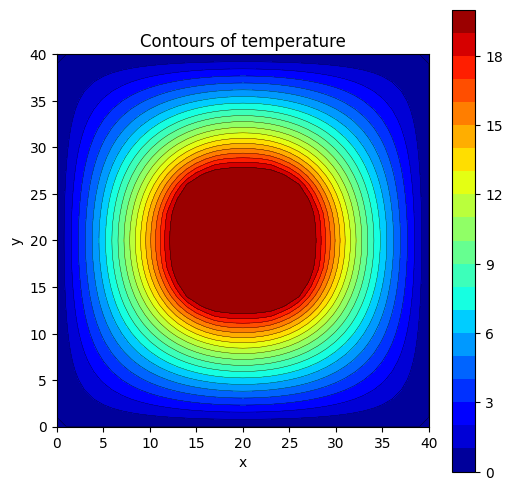

In [515]:
Atilde, b = BuildSystemSim(N, TL=0.0, TR=0.0, TB=0.0, TT=0.0, TC=20.0, R=0.2)
Atildesp = csc_matrix(Atilde)
xsol_dir = scipy.sparse.linalg.spsolve(Atildesp,b)
Tplot = xsol_dir.copy().reshape(N,N).T
PlotaTemperature(N,N,Tplot)

* Método dos gradientes conjugagdos

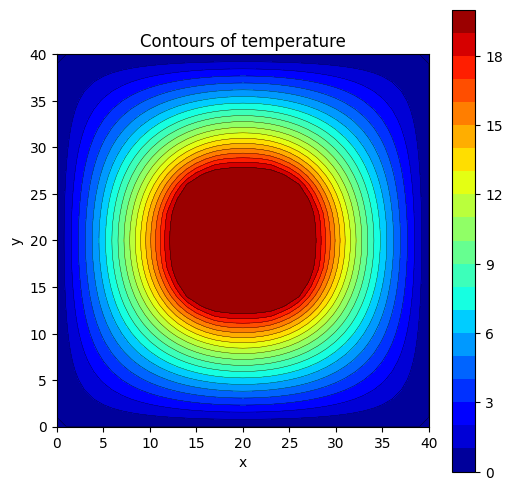

In [516]:
Atilde, b = BuildSystemSim(N, TL=0.0, TR=0.0, TB=0.0, TT=00.0, TC=20.0, R=0.2)
Atildesp = csc_matrix(Atilde)
xsol_cg, info = scipy.sparse.linalg.cg(Atildesp, b, rtol=1e-5,callback=cg_counter)
Tplot = xsol_cg.copy().reshape(N,N).T
PlotaTemperature(N,N,Tplot)

* Método dos resíduos mínimos generalizados

/tmp/ipykernel_4772/3126770645.py:3: DeprecationWarning: scipy.sparse.linalg.gmres called without specifying `callback_type`. The default value will be changed in a future release. For compatibility, specify a value for `callback_type` explicitly, e.g., ``gmres(..., callback_type='pr_norm')``, or to retain the old behavior ``gmres(..., callback_type='legacy')``
  xsol_gmres, info = scipy.sparse.linalg.gmres(Atildesp, b, rtol=1e-5, callback=gmres_counter)


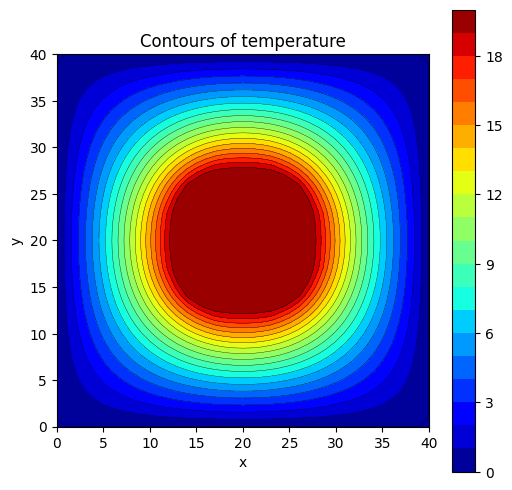

In [517]:
Atilde, b = BuildSystemSim(N, TL=0.0, TR=0.0, TB=0.0, TT=0.0, TC=20.0, R=0.2)
Atildesp = csc_matrix(Atilde)
xsol_gmres, info = scipy.sparse.linalg.gmres(Atildesp, b, rtol=1e-5, callback=gmres_counter)
Tplot = xsol_gmres.copy().reshape(N,N).T
PlotaTemperature(N,N,Tplot)

## 3 - Obtenção de Tempos de Cálculo

In [518]:
class gmres_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
    def __call__(self, rk=None):
        self.niter += 1
        if self._disp:
            print('iter %3i\trk = %s' % (self.niter, str(rk)))
            
import inspect
class cg_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
    def __call__(self, rk=None):
        self.niter += 1
        frame = inspect.currentframe().f_back
        if self._disp:
            print('iter %3i\trk = %f' % (self.niter, frame.f_locals['resid']))

# Armar um caso de grande porte: Matriz densa   
N = 81
start_time = time.time()
Atilde, b = BuildSystemSim(N, TL=0.0, TR=0.0, TB=0.0, TT=0.0, TC=20.0, R=0.2)
print("---Assembly: %s seconds ---" % (time.time() - start_time))


Atildesp = csc_matrix(Atilde)

# Examples of direct method (escalonamento)
print('\nMétodo direto\n')
start_time = time.time()
xsol_dir = scipy.sparse.linalg.spsolve(Atildesp,b)
print("---Tempo método Direto: %s seconds ---" % (time.time() - start_time))
            
# Example of conjugate gradient
print('\nMétodo iterativo CG')
start_time = time.time()
xsol_cg, info = scipy.sparse.linalg.cg(Atildesp, b, rtol=1e-5, callback= cg_counter)
print("---Tempo método cg: %s seconds ---" % (time.time() - start_time))

# Example of Generalized minimum residual
print('\nMétodo iterativo GMRES')
start_time = time.time()
xsol_gmres, info = scipy.sparse.linalg.gmres(Atildesp, b, rtol=1e-5, callback=gmres_counter)
print("---Tempo método gmres: %s seconds ---" % (time.time() - start_time))

---Assembly: 1.5801000595092773 seconds ---

Método direto

---Tempo método Direto: 0.009482622146606445 seconds ---

Método iterativo CG
---Tempo método cg: 0.006728172302246094 seconds ---

Método iterativo GMRES
---Tempo método gmres: 0.07847833633422852 seconds ---


/tmp/ipykernel_4772/2769879869.py:45: DeprecationWarning: scipy.sparse.linalg.gmres called without specifying `callback_type`. The default value will be changed in a future release. For compatibility, specify a value for `callback_type` explicitly, e.g., ``gmres(..., callback_type='pr_norm')``, or to retain the old behavior ``gmres(..., callback_type='legacy')``
  xsol_gmres, info = scipy.sparse.linalg.gmres(Atildesp, b, rtol=1e-5, callback=gmres_counter)
